# DataJoint Element for Calcium Imaging

Open-source data pipeline to automate analyses and organize data

<img src =../docs/src/images/rawscans.gif title="value" width="200" height="200"/>
<img src =../docs/src/images/motioncorrectedscans.gif width="200" height="200"/>
<img src =../docs/src/images/cellsegmentation.png width="200" height="200"/>
<img src =../docs/src/images/calciumtraces.png width="200" height="200"/> 

Left to right: Raw scans, Motion corrected scans, Cell segmentations, Calcium events

In this tutorial, we will walk through processing two-photon calcium imaging data collected from ScanImage and processed with Suite2p.

We will explain the following concepts as they relate to this pipeline:
- What is an Element versus a pipeline?
- Plot the pipeline with `dj.Diagram`
- Insert data into tables
- Query table contents
- Fetch table contents
- Run the pipeline for your experiments

For detailed documentation and tutorials on general DataJoint principles that support collaboration, automation, reproducibility, and visualizations:

- [DataJoint for Python - Interactive Tutorials](https://github.com/datajoint/datajoint-tutorials) - Fundamentals including table tiers, query operations, fetch operations, automated computations with the `make` function, etc.

- [DataJoint for Python - Documentation](https://datajoint.com/docs/core/datajoint-python/)

- [DataJoint Element for Calcium Imaging - Documentation](https://datajoint.com/docs/elements/element-calcium-imaging/)

Let's start by importing the packages necessary to run this pipeline. 

In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

[2023-06-08 00:13:21,344][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2023-06-08 00:13:21,347][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-06-08 00:13:21,369][INFO]: Connected root@fakeservices.datajoint.io:3306


## Combine multiple Elements into a pipeline

Each DataJoint Element is a modular set of tables that can be combined into a complete pipeline.

Each Element contains 1 or more modules, and each module declares its own schema in the database.

This tutorial pipeline is assembled from four DataJoint Elements.

| Element | Source Code | Documentation | Description |
| -- | -- | -- | -- |
| Element Lab | [Link](https://github.com/datajoint/element-lab) | [Link](https://datajoint.com/docs/elements/element-lab) | Lab management related information, such as Lab, User, Project, Protocol, Source. |
| Element Animal | [Link](https://github.com/datajoint/element-animal) | [Link](https://datajoint.com/docs/elements/element-animal) | General animal metadata and surgery information. |
| Element Session | [Link](https://github.com/datajoint/element-session) | [Link](https://datajoint.com/docs/elements/element-session) | General information of experimental sessions. |
| Element Calcium Imaging | [Link](https://github.com/datajoint/element-calcium-imaging) | [Link](https://datajoint.com/docs/elements/element-calcium-imaging) |  Calcium imaging analysis with Suite2p, CaImAn, and EXTRACT. |

By importing the modules for the first time, the schemas and tables will be created in the database.  Once created, importing modules will not create schemas and tables again, but the existing schemas/tables can be accessed.

The Elements are imported and activated within the `tutorial_pipeline` script.

In [ ]:
from tutorial_pipeline import lab, subject, session, scan, imaging, Equipment

Each Python module (e.g. `subject`) contains a schema object that enables interaction with the schema in the database.

In [ ]:
subject.schema

The Python classes in the module correspond to a table in the database server.

In [ ]:
subject.Subject()

## Diagram

Let's plot the diagram of tables within multiple schemas and their dependencies using `dj.Diagram()` (see [Diagram docs](https://datajoint.com/docs/core/concepts/getting-started/diagrams/)).

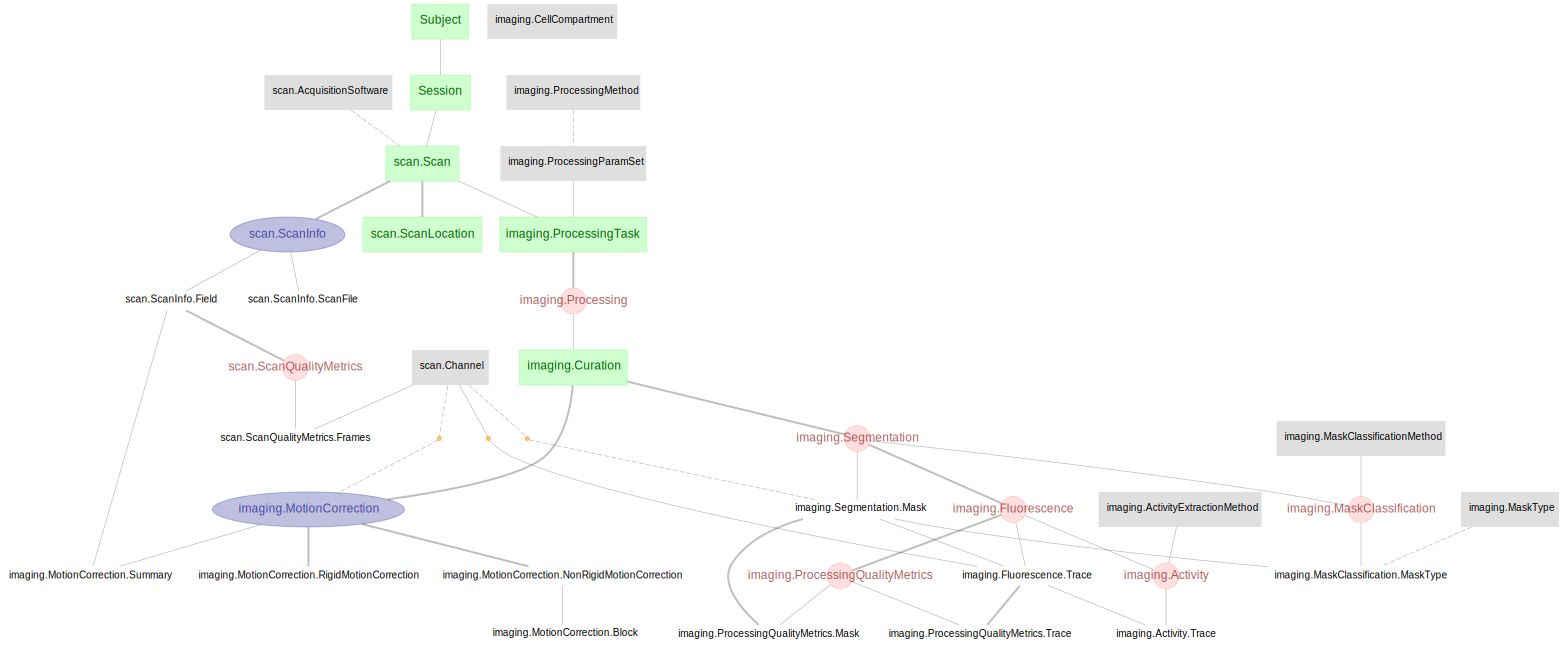

In [2]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(scan)
    + dj.Diagram(imaging)
)

#### Table Types

There are 5 table types in DataJoint.  Each of these appear in the diagram above.

| Table tier | Color and shape | Description |
| -- | -- | -- |
| Manual table | Green box | Data entered from outside the pipeline, either by hand or with external helper scripts. |
| Lookup table | Gray box | Small tables containing general facts and settings of the data pipeline; not specific to any experiment or dataset. |  
| Imported table | Blue oval | Data ingested automatically inside the pipeline but requiring access to data outside the pipeline. |
| Computed table | Red circle | Data computed automatically entirely inside the pipeline. |
| Part table | Plain text | Part tables share the same tier as their master table. |

The diagram becomes clear when it's approached as a hierarchy of tables that define the order in which the pipeline expects to receive data in each of the tables. 

The tables higher up in the diagram such as `subject.Subject()` should be the first to receive data.

Data is manually entered into the green rectangular tables with the `insert1()` method.

Tables connected by a line depend on entries from the table above it.
 
Tables with a purple oval or red circle will be automatically filled with relevant data
  by calling `populate()`. For example `scan.ScanInfo` and its part-table
  `scan.ScanInfo.Field` are both populated with `scan.ScanInfo.populate()`.

## DataJoint Basics

DataJoint pipelines can be run with four commands:
- `Insert`
- `Populate`
- `Query`
- `Fetch`

In this demo we will:
- `Insert` metadata about a subject, recording session, and 
  parameters related to processing calcium imaging data through Suite2p.

- `Populate` tables with outputs of image processing including motion correction,
  segmentation, fluorescence traces and deconvolved activity traces.

- `Query` the data from the database.

- `Fetch` and plot calcium activity traces.


## Insert entries into manual tables

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` functions.

In [3]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname=""  : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



In [4]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [5]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="F",
        subject_birth_date="2020-01-01",
        subject_description="ScanImage acquisition. Suite2p processing.",
    )
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,F,2020-01-01,ScanImage acquisition. Suite2p processing.


Let's repeat the steps above for the `Session` table.

In [6]:
print(session.Session.describe())

-> Subject
session_datetime     : datetime                     



In [7]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

Notice that `describe` displays the table definition with the dependencies (i.e. foreign key references). The `Session` table depends on the upstream `Subject` table. 

Whereas `heading` displays all the attributes of the table definition, regardless of
whether they are declared in an upstream table.

Next we can insert in the `session.Session` table by passing a dictionary to the `insert1` method.

In [8]:
session_key = dict(subject="subject1", session_datetime="2021-04-30 12:22:15.032")

In [9]:
session.Session.insert1(session_key)
session.Session()

subject,session_datetime
subject1,2021-04-30 12:22:15


The `SessionDirectory` table locates the relevant data files in a directory path
relative to the root directory defined in your `dj.config["custom"]`. More
information about `dj.config` is provided in the [User Guide](https://datajoint.com/docs/elements/user-guide/).

In [12]:
session.SessionDirectory.insert1(dict(**session_key, session_dir="subject1/session1"))
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject1,2021-04-30 12:22:15,subject1/session1


Next, we'll use `describe` and `heading` for the Scan table. Do you notice anything we
might have missed here? 

In [ ]:
print(scan.Scan.describe())

The `Scan` table's attributes include the `Session` table **and** the `Equipment` table.
Let's insert into the `Equipment` table and then `Scan`.

In [15]:
Equipment.insert1(dict(device="Mesoscope1", modality="Calcium imaging"))

In [16]:
scan.Scan.insert1(
    dict(
        **session_key,
        scan_id=0,
        device="Mesoscope1",
        acq_software="ScanImage",
        scan_notes="",
    )
)
scan.Scan()

subject,session_datetime,scan_id,device,acq_software,scan_notes
subject1,2021-04-30 12:22:15,0,Mesoscope1,ScanImage,


## Automatically populate tables

`scan.ScanInfo` is the first table in the pipeline that can be populated automatically with the `populate` method.

If a table contains a Part table, `populate()` inserts data into both.

Let's populate the `scan.ScanInfo` and its Part table `scan.ScanInfo.Field`.

In [17]:
scan.ScanInfo.heading

# General data about the resoscans/mesoscans from header
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
y=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
z=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : flo

In [18]:
scan.ScanInfo.Field.heading

# field-specific scan information
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
field_idx            : int                          # 
---
px_height            : smallint                     # height in pixels
px_width             : smallint                     # width in pixels
um_height=null       : float                        # height in microns
um_width=null        : float                        # width in microns
field_x=null         : float                        # (um) center of field in the motor coordinate system
field_y=null         : float                        # (um) center of field in the motor coordinate system
field_z=null         : float                        # (um) relative depth of field
delay_image=null     : longblob                     # (ms) delay between the start of the scan and pixels in this field
roi=null             : int                 

In [19]:
scan.ScanInfo()

subject,session_datetime,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,bidirectional_z true = bidirectional z-scan


In [20]:
scan.ScanInfo.Field()

subject,session_datetime,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans


In [21]:
# duration depends on your network bandwidth to s3
scan.ScanInfo.populate(display_progress=True)

ScanInfo: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Let's view the information was entered into these tables.

In [22]:
scan.ScanInfo()

subject,session_datetime,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,bidirectional_z true = bidirectional z-scan
subject1,2021-04-30 12:22:15,0,1,1,1,3000,0,13441.9,15745.0,-205821.0,29.2398,1,63.0981,0.712867,None,102.6,None


In [23]:
scan.ScanInfo.Field()

subject,session_datetime,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
subject1,2021-04-30 12:22:15,0,0,512,512,nan,nan,13441.9,15745.0,-205821.0,=BLOB=,None


Let's define the Suite2p parameters by making an entry in the `ProcessingParamSet` table.

In [25]:
import suite2p

params_suite2p = suite2p.default_ops()
params_suite2p["nonrigid"] = False

imaging.ProcessingParamSet.insert_new_params(
    processing_method="suite2p",
    paramset_idx=0,
    params=params_suite2p,
    paramset_desc="Calcium imaging analysis with Suite2p using default parameters",
)

The `ProcessingTask` table is used to select the `ProcessingParamSet` entry that is used to process a selected `Scan` entry in the downstream tables.

In [26]:
print(imaging.ProcessingTask.describe())

# Manual table for defining a processing task ready to be run
-> scan.Scan
-> imaging.ProcessingParamSet
---
processing_output_dir : varchar(255)                 # Output directory of the processed scan relative to root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation



In [ ]:
imaging.ProcessingTask.heading

The `ProcessingParamSet` table contains two important attributes: 
+ `paramset_idx` - Allows the user to choose the parameter set with which
you want to run image processing.
+ `task_mode` - Can be set to `load` or `trigger`. When set to `load`,
running the processing step initiates a search for existing output files of the image
processing algorithm defined in `ProcessingParamSet`. When set to `trigger`, the
processing step will run image processing on the raw data. 

In [28]:
imaging.ProcessingTask.insert1(
    dict(
        **session_key,
        scan_id=0,
        paramset_idx=0,
        task_mode="load",  # load or trigger
        processing_output_dir="subject1/session1/suite2p",
    )
)

Let's call populate on the `Processing` table, which checks the Suite2p results since `task_mode=load`.

In [29]:
imaging.Processing.populate(session_key, display_progress=True)

Processing: 100%|██████████| 1/1 [00:00<00:00, 48.47it/s]


Once processing is complete, you can optionally curate the output of Suite2p using the `Curation` table.

In [30]:
imaging.Curation.heading

# Curation(s) results
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
paramset_idx         : smallint                     # Unique parameter set ID.
curation_id          : int                          # 
---
curation_time        : datetime                     # Time of generation of this set of curated results
curation_output_dir  : varchar(255)                 # Output directory of the curated results, relative to root data directory
manual_curation      : tinyint                      # Has manual curation been performed on this result?
curation_note=""     : varchar(2000)                # 

In [31]:
imaging.Curation.insert1(
    dict(
        **session_key,
        scan_id=0,
        paramset_idx=0,
        curation_id=0,
        curation_time="2021-04-30 12:22:15.032",
        curation_output_dir="subject1/session1/suite2p",
        manual_curation=False,
        curation_note="",
    )
)

Now, we will populate several tables that store the output of image processing, including
`MotionCorrection`, `Segmentation`, `Fluorescence`, and `Activity`.

In [32]:
imaging.MotionCorrection.populate(display_progress=True)
imaging.Segmentation.populate(display_progress=True)
imaging.Fluorescence.populate(display_progress=True)
imaging.Activity.populate(display_progress=True)

MotionCorrection: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


## Query

Queries allow you to view the contents of the database.  The simplest query is the instance of the table class.

In [ ]:
subject.Subject()

Let's query the contents of the `Mask` part table.

In [ ]:
imaging.Segmentation.Mask()

With the `&` operator, we will restrict the contents of the `imaging.Segmentation.Mask` table to the entry where the `mask` attribute is 10.

In [ ]:
imaging.Segmentation.Mask & "mask = '10'"

DataJoint queries can be a highly flexible tool with several [operators](https://datajoint.com/docs/core/concepts/query-lang/operators/).  The next operator we will explore is `join` which combines matching information from tables.

First let's view the contents of each table.

In [ ]:
imaging.Segmentation.Mask()

In [ ]:
imaging.MaskClassification.MaskType()

Let's use the `join` operator to combine matching information in `imaging.Segmentation.Mask` and `imaging.MaskClassification.MaskType`.   The result contains all matching combinations of entities from both arguments.

In [ ]:
imaging.Segmentation.Mask * imaging.MaskClassification.MaskType

We can chain these operators together.

In [ ]:
imaging.Segmentation.Mask * imaging.MaskClassification.MaskType & "mask = '10'"

## Fetch

The `fetch` and `fetch1` methods download the data from the query object into the workspace.

Below we will run `fetch()` to return all attributes of all entries in the table.

In [ ]:
imaging.Fluorescence.Trace.fetch(as_dict=True)

Next, we will fetch the `fluorescence` attribute for `mask=10` with the `fetch1` method by passing the attribute as an argument to the method.

By default, `fetch1()` returns all attributes of one of the entries in the table.  If a query has multiple entries, `fetch1()` imports the first entry in the table.

In [38]:
trace = (imaging.Fluorescence.Trace & "mask = '10'").fetch1("fluorescence")

Let's plot this trace.  First we will fetch the sampling rate of the data to define the x-axis values.

In [ ]:
sampling_rate = (scan.ScanInfo & session_key & "scan_id=0").fetch1("fps")

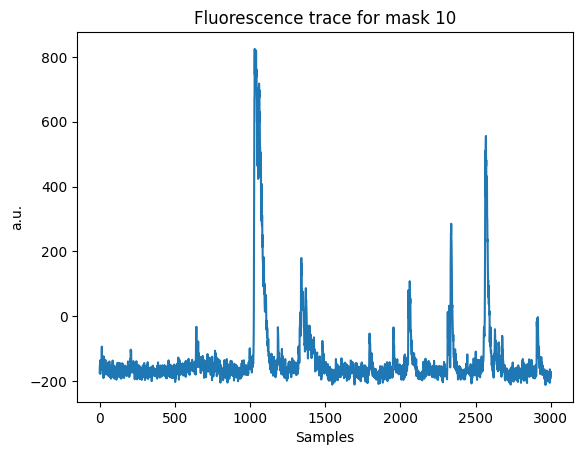

In [39]:
plt.plot(np.r_[: trace.size] * 1 / sampling_rate, trace)
plt.title("Fluorescence trace for mask 10")
plt.xlabel("Time (s)")
plt.ylabel("Activity (a.u.)");

We will fetch and plot the average, motion-corrected image.

In [ ]:
average_image = (imaging.MotionCorrection.Summary & session_key & "field_idx=0").fetch1(
    "average_image"
)

In [ ]:
plt.imshow(average_image)

We will fetch mask coordinates and overlay these on the average image.

In [46]:
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & session_key
    & "mask_center_z=0"
    & "mask_npix > 130"
).fetch("mask_xpix", "mask_ypix")

In [47]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

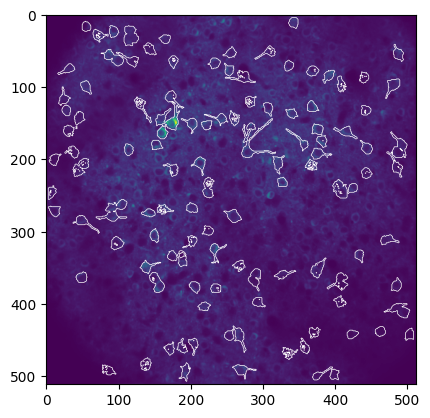

In [48]:
plt.imshow(average_image)
plt.contour(mask_image, colors="white", linewidths=0.5);

This Element includes an interactive widget to plot the segmentations and traces to visualize the results after processing with Suite2p, CaImAn, or EXTRACT.

First, let's populate the `imaging_report` table with these plots, and then we can visualize the plots with the widget.

In [ ]:
imaging_report.ScanLevelReport.populate(session_key, display_progress=True)
imaging_report.TraceReport.populate(session_key, display_progress=True)

In [ ]:
from element_calcium_imaging import plotting

In [ ]:
plotting.widget.main(imaging)

Congratulations!  You have learned about the DataJoint Element for Calcium Imaging and common DataJoint commands to interact with the pipeline, including insert, populate, query, and fetch.

## Next steps

Follow the steps below to run this pipeline for your experiments:

- Create a fork of this repository to your GitHub account.
- Clone the repository to your local machine and configure for use with the instructions in the [User Guide](https://datajoint.com/docs/elements/user-guide/).
- The DataJoint team offers free [Office Hours](https://datajoint.com/docs/community/support/) to help you setup this pipeline.
- If you have any questions, please reach out at support@datajoint.com.